<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de texto con RNN<a id="top"></a>

<i><small>Última actualización: 2023-05-11</small></i></div>

***

## Introducción

En un _notebook_ anterior exploramos la clasificación de textos con CNN, las cuales son adecuadas para capturar dependencias locales en datos de texto. Sin embargo, a veces necesitamos un modelo más potente que pueda capturar dependencias a largo plazo en los datos. Aquí es donde entran en juego las RNN.

Las RNN están diseñadas específicamente para modelar datos secuenciales, lo que las hace ideales para tareas de clasificación de texto. A diferencia de las redes neuronales tradicionales, que procesan las entradas independientemente unas de otras, las RNN mantienen una memoria de las entradas anteriores y utilizan esta información para hacer predicciones sobre la entrada actual.

## Objetivos

Vamos a explorar cómo utilizar RNN para la clasificación de texto en el mismo problema que en el _notebook_ donde clasificábamos las reseñas de Amazon que los usuarios hicieron sobre los productos mediante CNN, pero esta vez con RNN.

Veremos que en realidad los cambios son mínimos, ya que es poco más que cambiar una capa por otra.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import os
import numpy as np
import requests
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from shutil import unpack_archive

import matplotlib.pyplot as plt

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Y crearemos los directorios necesarios en caso de que no se hayan creado previamente

In [3]:
os.makedirs('tmp', exist_ok=True)

***

## Parámetros comunes

Mantendremos los mismos parámetros globales para poder comparar ambos métodos.

In [4]:
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 16384
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 32
EPOCHS = 2
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_PATH = "tmp/glove.6B.300d.txt"

## Preprocesamiento de datos

El proceso que llevaremos a cabo será el mismo que hicimos en el _notebook_ anterior.

### Descarga del _dataset_ ...

In [5]:
DATASET_URL = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
DATASET_ZIP = 'tmp/Digital_Music_5.json.gz'

# Download the remote file if it does not exist
if not os.path.exists(DATASET_ZIP):
    with open(DATASET_ZIP, 'wb') as f:
        print(f'Downloading {DATASET_ZIP}...')
        r = requests.get(DATASET_URL, verify=False)
        f.write(r.content)
        print('OK')

corpus = pd.read_json(DATASET_ZIP, lines=True)
corpus.dropna(subset=['overall', 'reviewText'], inplace=True)
corpus.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


### ... preparación de las entradas ...

In [6]:
x_train = corpus['reviewText'].astype(str).str.strip()
print(f'Training input shape: {x_train.shape}')

Training input shape: (169623,)


### ... de las salidas ...

In [7]:
y_train = corpus['overall'].astype(int).replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2,
})
print(f'Training output shape: {y_train.shape}')

Training output shape: (169623,)


In [8]:
print(type(x_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### los _embeddings_ preentrenados de GloVe ...

In [9]:
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Unzip in the directory 'glove'.
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


### ... cogiendo los pesos de las `MAX_VOCAB_SIZE` palabras más comunes ...

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
import torch
import numpy as np

def yield_tokens(corpus):
    """Iterador que genera listas de tokens a partir del corpus"""
    for text in corpus:
        yield text.split()  # tenemos el corpus tokenizado por espacios

def load_glove_embeddings(glove_path, corpus, embedding_dim, max_vocab_size):
    print("Building vocabulary... ", end="")
    
    # vocabulario a partir del corpus
    vocab = build_vocab_from_iterator(yield_tokens(corpus), specials=["<unk>", "<pad>"], max_tokens=max_vocab_size+2)
    vocab.set_default_index(vocab["<unk>"])
    
    print(f"done ({len(vocab)} words).")
    
    print("Loading GloVe embeddings... ", end="")
    word2vec = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word2vec[word] = vector
    
    print("done.")

    print("Creating embedding matrix with GloVe vectors... ", end="")
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    unassigned_words = 0

    for word, idx in vocab.get_stoi().items():
        if idx >= max_vocab_size + 2:
            continue  # saltamos si el índice supera el tamaño máximo del vocabulario

        if word == "<unk>":
            word = "unk"  # compatibilidad con GloVe >:(

        word_vector = word2vec.get(word)
        if word_vector is not None:
            embedding_matrix[idx] = word_vector
        else:
            unassigned_words += 1

    print(f"Number of words in GloVe: {len(word2vec)}")
    print(f"Done ({unassigned_words} words unassigned).")
    print(f"Vocab length: {len(vocab)}")

    return vocab, torch.tensor(embedding_matrix, dtype=torch.float)


In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_index, max_len):
        self.texts = [[word_index.get(word, 1) for word in text.split()] for text in texts]
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = self.texts[idx]
        x = x[:self.max_len] + [0] * (self.max_len - len(x))  # Padding
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [12]:
texts = x_train.values
labels = y_train.values

word_index = {word: i+2 for i, word in enumerate({word for text in texts for word in text.split()})}
# Make sure that no index exceeds MAX_VOCAB_SIZE
word_index = {word: min(i + 2, MAX_VOCAB_SIZE + 1) for word, i in word_index.items()}

embedding_matrix = load_glove_embeddings(GLOVE_PATH, word_index, EMBEDDING_DIM, MAX_VOCAB_SIZE)


train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_texts, train_labels, word_index, MAX_SEQUENCE_LENGTH)
val_dataset = TextDataset(val_texts, val_labels, word_index, MAX_SEQUENCE_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading GloVe embeddings... done.
Creating embedding matrix with GloVe vectors... Number of words in GloVe: 400000
Done (168190 words unassigned).


### ... y cargándolos dentro de la capa de `Embedding`

In [13]:
embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)

/var/folders/gc/mmq5zm5n1rg71ck5xqfyp8hh0000gn/T/ipykernel_77958/1180853728.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)


## Clasificación basada en redes neuronales recurrentes

Y ahora, en lugar de utilizar CNN, utilizaremos RNN. En este caso, el conjunto de dimensiones lo realizan la capa `TextVectorization` (que convierte el texto en secuencias de enteros de longitud $T$) y la capa Embedding (que convierte cada entero en un vector de dimensiones $D$), convirtiendo la entrada en un tensor con la forma $N \times T \times D$.

In [14]:
class TextClassificationRNN(nn.Module):
    def __init__(self, embedding_matrix, embedding_dim, num_classes):
        super(TextClassificationRNN, self).__init__()
        # Crear la capa de embedding usando la matriz preentrenada
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, 64, batch_first=True)  # GRU con 64 unidades ocultas
        self.fc = nn.Linear(64, num_classes)  # Capa de salida para clasificación

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, hidden = self.gru(embedded)  # hidden: [1, batch_size, hidden_dim]
        return self.fc(hidden.squeeze(0))  # [batch_size, num_classes]

    def fit(self, train_loader, val_loader, criterion, optimizer, device, epochs):
        self.to(device)
        history = {
            "train_loss": [],
            "val_acc": [],
            "val_report": []
        }
        
        for epoch in range(epochs):
            # Entrenamiento
            self.train()
            total_loss = 0
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            history["train_loss"].append(avg_loss)

            # Evaluación
            val_acc, val_report = self.evaluate(val_loader, device)
            history["val_acc"].append(val_acc)
            history["val_report"].append(val_report)

            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}")
            print(val_report)

        return history

    def evaluate(self, val_loader, device):
        self.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(true_labels, predictions)
        report = classification_report(true_labels, predictions, zero_division=0)
        return accuracy, report

Aunque el número de parámetros es similar, aumentar el número de unidades en una unidad recurrente no aumenta mucho el número de parámetros en nuestro modelo. Sin embargo, sí que aumentará mucho el tiempo de entrenamiento. Por lo tanto, nuestro modelo no podrá obtener resultados tan buenos como los anteriores.

Entrenemos el modelo y esperemos que todo vaya bien (otra vez)

In [15]:
NUM_CLASSES = len(set(labels))
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear modelo
model = TextClassificationRNN(embedding_matrix, EMBEDDING_DIM, NUM_CLASSES)

# Optimizer y pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Entrenar modelo
history = model.fit(train_loader, val_loader, criterion, optimizer, DEVICE, EPOCHS)

/var/folders/gc/mmq5zm5n1rg71ck5xqfyp8hh0000gn/T/ipykernel_77958/3936320419.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
Epoch 1/2 - Training: 100%|██████████| 4241/4241 [03:19<00:00, 21.23it/s]



Epoch 1/2
Train Loss: 0.2614, Val Accuracy: 0.9371
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       782
           1       0.45      0.04      0.07      1365
           2       0.94      1.00      0.97     31778

    accuracy                           0.94     33925
   macro avg       0.66      0.36      0.37     33925
weighted avg       0.91      0.94      0.91     33925



Epoch 2/2 - Training: 100%|██████████| 4241/4241 [04:07<00:00, 17.13it/s]  



Epoch 2/2
Train Loss: 0.2365, Val Accuracy: 0.9369
              precision    recall  f1-score   support

           0       0.42      0.12      0.19       782
           1       0.59      0.03      0.05      1365
           2       0.94      1.00      0.97     31778

    accuracy                           0.94     33925
   macro avg       0.65      0.38      0.40     33925
weighted avg       0.91      0.94      0.91     33925



Echemos un vistazo al progreso del entrenamiento:

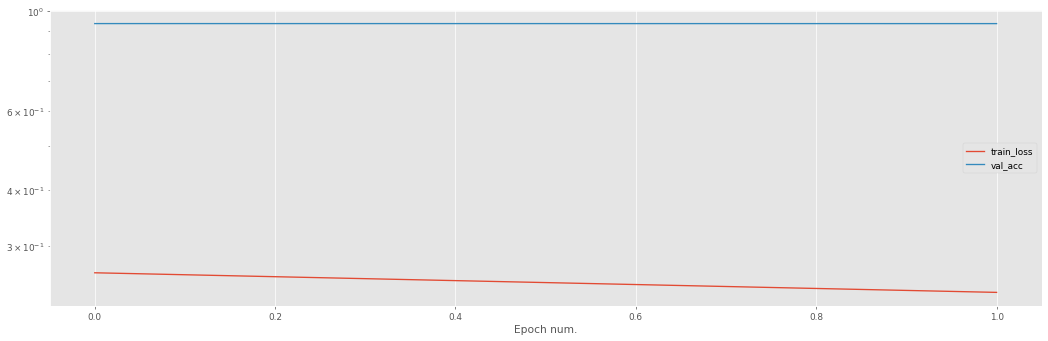

In [16]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Veamos ahora cómo interpreta el sentimiento de una reseña buena, regular y mala extraída del sitio web de amazon.

In [17]:
good = "My nephew is on the autism spectrum and likes to fidget with things so I knew this toy would be a hit. Was concerned that it may not be \"complex\" enough for his very advanced brain but he really took to it. Both him (14 yrs) and his little brother (8 yrs) both enjoyed playing with it throughout Christmas morning. I'm always happy when I can find them something unique and engaging."
poor = "I wasn't sure about this as it's really small. I bought it for my 9 year old grandson. I was ready to send it back but my daughter decided it was a good gift so I'm hoping he likes it. Seems expensive for the price though to me."
evil = "I just wanted to follow up to say that I reported this directly to the company and had no response. I have not gotten any response from my review. The level of customer service goes a long way when an item you purchase is defective and this company didn’t care to respond. No I am even more Leary about ordering anything from this company. I never asked for a refund or replacement since I am not able to return it. I’m just wanted to let them know that this was a high dollar item and I expected it to be a quality item. Very disappointed! I bought this for my grandson for Christmas. He loved it and played with it a lot. My daughter called to say that the stickers were peeling on the corners. I am not able to take it from my grandson because he is autistic and wouldn’t understand. I just wanted to warn others who are wanting to get this. Please know that this is a cool toy and it may not happen to yours so it is up to you."

test_texts = [good, poor, evil]
test_labels = [2, 1, 0]  # good, poor, evil
test_dataset = TextDataset(test_texts, test_labels, word_index, MAX_SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
print("\nTest Results:")
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs, dim=1).item()
        print(f"Sample {i + 1} classified as: {predicted_class}")


Test Results:
Sample 1 classified as: 2
Sample 2 classified as: 2
Sample 3 classified as: 2


## Conclusiones

Hemos estudiado cómo utilizar RNN para clasificar textos y las hemos comparado con las CNN. Aunque ambas arquitecturas pueden ser eficaces para la clasificación de textos, presentan algunas diferencias clave.

La principal es las RNN son más adecuadas para captar las dependencias a largo plazo en los datos de texto, mientras que las CNN son más adecuadas para captar las dependencias locales. Esto hace que las RNN sean una buena opción para tareas como el análisis de sentimientos o la traducción de idiomas, donde el contexto de una palabra o frase puede ser crucial para determinar su significado.

Sin embargo, el entrenamiento de las RNN puede ser más costoso que el de las CNN (ya hemos visto el tiempo que tarda una red pequeña en ser entrenada durante 5 _epochs_). Por otro lado, las CNN son más rápidas de entrenar y se adaptan mejor a conjuntos de datos más grandes. Son especialmente adecuadas para tareas como la clasificación de textos o el reconocimiento de imágenes, en las que las características locales son importantes.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>